**Завдання:**

Використовуючи тренувальний датасет з архіву data.zip та матеріали з додаткових джерел, спробуйте побудувати систему детекції медичних масок на обличчі.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import shutil
import cv2
import numpy as np
from tensorflow.keras.models import load_model

**1. Завантаження датасету. Створення навчаючої та тестової вибірки.**

In [2]:
source_dir = 'data'

train_dir = 'train_data'

test_dir = 'test_data'

shutil.rmtree(train_dir)
shutil.rmtree(test_dir)

test_size = 0.2

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for folders in ('with_mask', 'without_mask'):
    os.makedirs(os.path.join(train_dir, folders))
    os.makedirs(os.path.join(test_dir, folders))

for categoria_folder in os.listdir(source_dir):
    source_categoria_dir = os.path.join(source_dir, categoria_folder)
    train_categoria_dir = os.path.join(train_dir, categoria_folder)
    test_categoria_dir = os.path.join(test_dir, categoria_folder)

    image_files = os.listdir(source_categoria_dir)
    train_files, test_files = train_test_split(image_files, test_size=test_size)

    os.makedirs(train_categoria_dir, exist_ok=True)
    os.makedirs(test_categoria_dir, exist_ok=True)

    for file_name in train_files:
        source_path = os.path.join(source_categoria_dir, file_name)
        train_path = os.path.join(train_categoria_dir, file_name)
        shutil.copyfile(source_path, train_path)

    for file_name in test_files:
        source_path = os.path.join(source_categoria_dir, file_name)
        test_path = os.path.join(test_categoria_dir, file_name)
        shutil.copyfile(source_path, test_path)

**2. Навчання моделі.**

In [3]:
# Шляхи до навчальної та тестової вибірок. Шлях збереження моделі.
train_dir = 'train_data'
test_dir = 'test_data'
path_to_save = 'Results'

img_height, img_width = 224, 224
batch_size = 16

# Створення генератора зображень
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   shear_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

# Стоврення генераторів зображень для навчання моделі
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size)


# Створення моделі
model = Sequential([
    Conv2D(100, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    Conv2D(100, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(2, activation='softmax')
])

# Компіляція моделі
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Навчання моделі
model.fit(train_generator,
          steps_per_epoch=train_generator.samples // batch_size,
          validation_data=test_generator,
          validation_steps=test_generator.samples // batch_size,
          epochs=20)

# Збереження моделі
accuracy = model.evaluate(test_generator)[1]
print('Accuracy:', accuracy)

model.save(path_to_save + '/mask_detection_model_01.h5')

Found 1100 images belonging to 2 classes.
Found 276 images belonging to 2 classes.
Epoch 1/20
68/68 [==============================] - 112s 2s/step - loss: 0.5802 - accuracy: 0.7768 - val_loss: 0.4271 - val_accuracy: 0.8382
Epoch 2/20
68/68 [==============================] - 104s 2s/step - loss: 0.3275 - accuracy: 0.8681 - val_loss: 0.1442 - val_accuracy: 0.9522
Epoch 3/20
68/68 [==============================] - 115s 2s/step - loss: 0.2244 - accuracy: 0.9151 - val_loss: 0.1262 - val_accuracy: 0.9632
Epoch 4/20
68/68 [==============================] - 110s 2s/step - loss: 0.2389 - accuracy: 0.9114 - val_loss: 0.1544 - val_accuracy: 0.9228
Epoch 5/20
68/68 [==============================] - 104s 2s/step - loss: 0.1709 - accuracy: 0.9382 - val_loss: 0.1134 - val_accuracy: 0.9559
Epoch 6/20
68/68 [==============================] - 104s 2s/step - loss: 0.1646 - accuracy: 0.9373 - val_loss: 0.0876 - val_accuracy: 0.9743
Epoch 7/20
68/68 [==============================] - 103s 2s/step - loss

**3. Використання моделі.**

In [4]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
mask_net = load_model('mask_detection_model_01.h5')
cap = cv2.VideoCapture(0)

while True:
    
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        face_roi = frame[y:y+h, x:x+w]
        resized = cv2.resize(face_roi,(224,224))
        normalized = resized/255.0
        result_img = np.reshape(normalized,(1,224,224,3))
        result_img = np.vstack([result_img])
        predictions = mask_net.predict(result_img)
        class_idx = int(predictions.argmax(axis=1))
        label = "Mask" if class_idx == 1 else "No Mask"
        color = (0, 255, 0) if class_idx == 1 else (0, 0, 255)
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    cv2.imshow('Mask Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 57ms/step


**З. Завантаження прикладу предикції.**

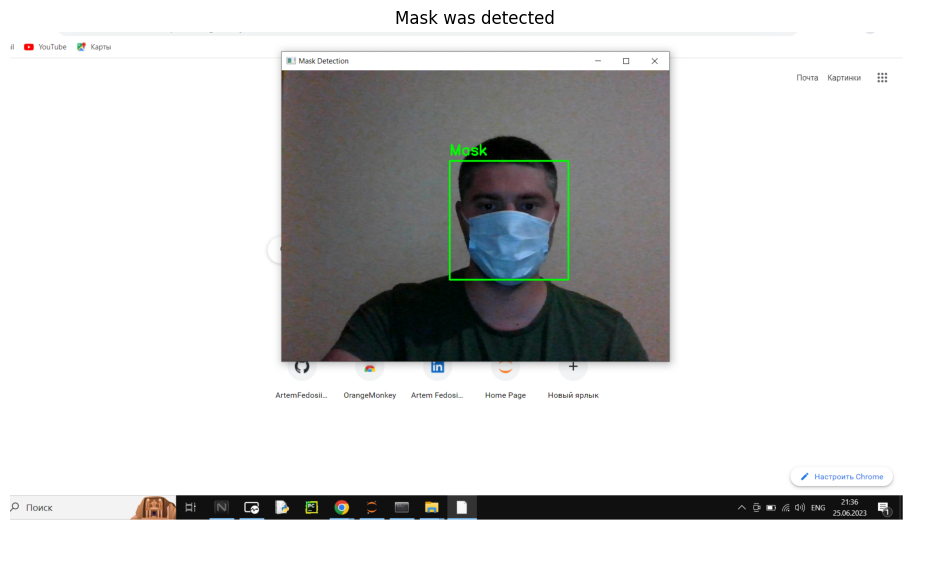

In [5]:
import matplotlib.pyplot as plt

w_mask = cv2.imread('w_mask.png')
wo_mask = cv2.imread('wo_mask.png')

plt.figure(figsize=[12, 8])
plt.imshow(cv2.cvtColor(w_mask, cv2.COLOR_BGR2RGB))
plt.title("Mask was detected")
plt.axis('off')
plt.show()

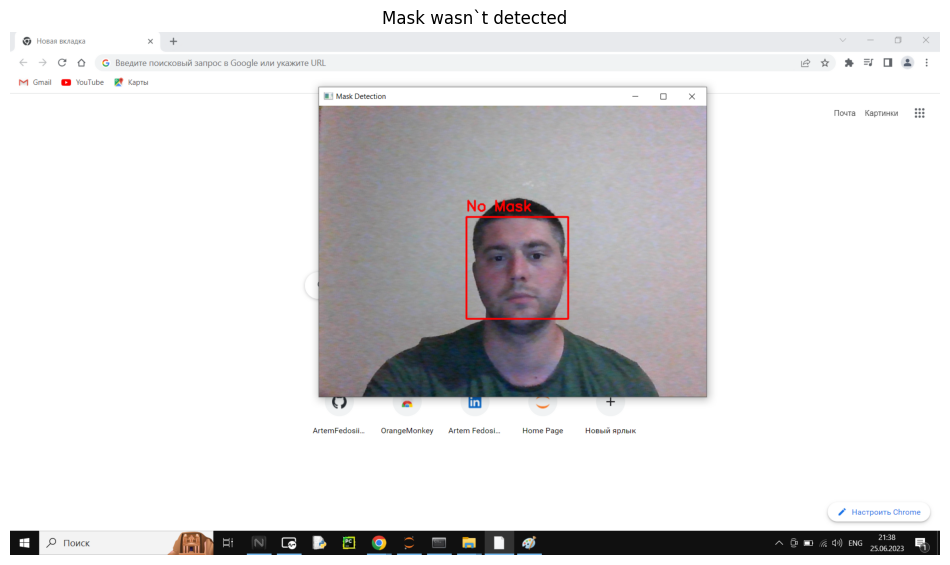

In [6]:
plt.figure(figsize=[12, 8])
plt.imshow(cv2.cvtColor(wo_mask, cv2.COLOR_BGR2RGB))
plt.title("Mask wasn`t detected")
plt.axis('off')
plt.show()